In [1]:
from sample_size_experiment import *

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from IPython.display import display

from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

## Iris Dataset (Test Functionality)

Run each model on a small sample dataset

In [3]:
from random import sample

def random_sample(X, y, samples):
    
    ordered_indices = [num for num in range(samples)]
    random_indices = sample(ordered_indices, samples)

    X = X[random_indices]
    y = y[random_indices]

    return X, y

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()

X = np.array(data['data'], dtype=np.float32)
y = np.array(data['target'], dtype=np.float32)

random_forest_classification_errors = []
parametric_dnn_classification_errors = []

for max_sample_size in range(30,X.shape[0],10):
    
    X_scaled, y_scaled = random_sample(X, y, max_sample_size)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=101)

    rf_model = random_forest_classifier_model(X_train = X_train,
                                              y_train = y_train, 
                                              num_trees = 20, 
                                              max_depth = None, 
                                              verbose = 1
                                             )
    rf_predictions = rf_model.predict(X_test)
    rf_error = 1 - accuracy_score(y_test, rf_predictions)

    random_forest_classification_errors.append(rf_error)
    
    y_train=to_categorical(y_train,num_classes=3)
    y_test=to_categorical(y_test,num_classes=3)

    dnn_model = parametric_deep_neural_network(X_train = X_train,
                                               y_train = y_train, 
                                               epochs = 20,
                                               batch_size = 1, 
                                               learning_rate = 0.001,
                                               validation_split = 0.3,
                                               verbose = 1
                                              )

    score = dnn_model.evaluate(X_test, y_test, batch_size=None, verbose=0, sample_weight=None, steps=None,
                    callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                    return_dict=False)

    dnn_error = 1 - score[1]
    parametric_dnn_classification_errors.append(dnn_error)

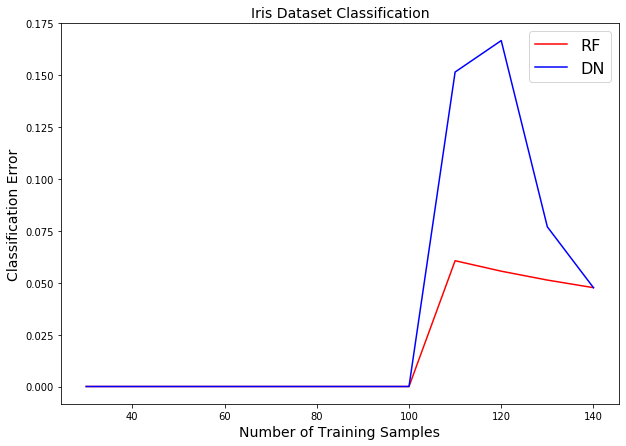

In [12]:
plt.figure(figsize = (10,7))
plt.plot(range(30,X.shape[0],10), random_forest_classification_errors, color= 'r')
plt.plot(range(30,X.shape[0],10), parametric_dnn_classification_errors, color= 'b')
plt.title('Iris Dataset Classification', fontsize=14)
plt.ylabel('Classification Error', fontsize=14)
plt.xlabel('Number of Training Samples', fontsize=14)
plt.legend(['RF', 'DN'], prop={'size': 16})

## Sparce Parity Dataset Creation

In [4]:
X_parity = np.random.uniform(-1,1,[30000,20])

In [5]:
def sparce_parity_labels(X, p_star):
    q = np.zeros(X.shape[0])
    y = np.where(X[:,:3] >= 0, 1, 0)
    return np.sum(y, axis = 1) % 2

In [6]:
y_parity = sparce_parity_labels(X_parity, 3)

In [7]:
np.array(X_parity, dtype=np.float32).shape

(30000, 20)

In [8]:
from sklearn.model_selection import train_test_split

X = np.array(X_parity, dtype=np.float32)
y = np.array(y_parity, dtype=np.float32)

iterations = 5

sample_sizes = [500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 30000]

rf_evolution = np.zeros((len(sample_sizes), iterations))
dnn_evolution = np.zeros((len(sample_sizes), iterations))

# sample_sizes = [500, 1000, 2000]

for iteration in range(iterations):
    print(iteration)
    
    for sample_size_index, max_sample_size in enumerate(sample_sizes):
        print(max_sample_size)

        X_scaled, y_scaled = random_sample(X, y, max_sample_size)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=101)

        rf_model = random_forest_classifier_model(X_train = X_train,
                                                  y_train = y_train, 
                                                  num_trees = 64, 
                                                  max_depth = 3, 
                                                  verbose = 1
                                                 )
        rf_predictions = rf_model.predict(X_test)
        rf_error = 1 - accuracy_score(y_test, rf_predictions)

        rf_evolution[sample_size_index][iteration] = rf_error

    #     y_train=to_categorical(y_train,num_classes=3)
    #     y_test=to_categorical(y_test,num_classes=3)

        dnn_model = parametric_deep_neural_network(X_train = X_train,
                                                   y_train = y_train, 
                                                   epochs = 10,
                                                   batch_size = 1, 
                                                   learning_rate = 0.001,
                                                   validation_split = 0.3,
                                                   verbose = 1
                                                  )

        score = dnn_model.evaluate(X_test, y_test, batch_size=None, verbose=0, sample_weight=None, steps=None,
                        callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False,
                        return_dict=False)

        dnn_error = 1 - score[1]
        dnn_evolution[sample_size_index][iteration] = dnn_error


0
500
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


244/244 [==============================] - 0s 1ms/step - loss: 0.7036 - accuracy: 0.4508 - val_loss: 0.6927 - val_accuracy: 0.5377
Epoch 2/10
244/244 [==============================] - 0s 812us/step - loss: 0.6966 - accuracy: 0.5164 - val_loss: 0.6931 - val_accuracy: 0.5283
Epoch 3/10
244/244 [==============================] - 0s 811us/step - loss: 0.6926 - accuracy: 0.5656 - val_loss: 0.6948 - val_accuracy: 0.5283
Epoch 4/10
244/244 [==============================] - 0s 809us/step - loss: 0.6893 - accuracy: 0.5656 - val_loss: 0.6955 - val_accuracy: 0.5377
Epoch 5/10
244/244 [==============================] - 0s 809us/step - loss: 0.6851 - accuracy: 0.5697 - val_loss: 0.6968 - val_accuracy: 0.5472
Epoch 6/10
244/244 [==============================] - 0s 813us/step - loss: 0.6801 - accuracy: 0.6066 - val_loss: 0.7001 - val_accuracy: 0.5377
Epoch 7/10
244/244 [==============================] - 0s 805us/step - loss: 0.6742 - accuracy: 0.6148 - val_loss: 0.7003 - val_accuracy: 0.5094
Epoch

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


489/489 [==============================] - 0s 900us/step - loss: 0.7242 - accuracy: 0.4663 - val_loss: 0.6992 - val_accuracy: 0.5213
Epoch 2/10
489/489 [==============================] - 0s 778us/step - loss: 0.6991 - accuracy: 0.5194 - val_loss: 0.6918 - val_accuracy: 0.5735
Epoch 3/10
489/489 [==============================] - 0s 767us/step - loss: 0.6896 - accuracy: 0.5460 - val_loss: 0.6900 - val_accuracy: 0.5498
Epoch 4/10
489/489 [==============================] - 0s 863us/step - loss: 0.6840 - accuracy: 0.5542 - val_loss: 0.6851 - val_accuracy: 0.5877
Epoch 5/10
489/489 [==============================] - 0s 811us/step - loss: 0.6763 - accuracy: 0.5828 - val_loss: 0.6842 - val_accuracy: 0.5687
Epoch 6/10
489/489 [==============================] - 0s 759us/step - loss: 0.6687 - accuracy: 0.5930 - val_loss: 0.6816 - val_accuracy: 0.5498
Epoch 7/10
489/489 [==============================] - 0s 764us/step - loss: 0.6602 - accuracy: 0.6176 - val_loss: 0.6849 - val_accuracy: 0.5450
Epo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
979/979 [==============================] - 1s 818us/step - loss: 0.6967 - accuracy: 0.4760 - val_loss: 0.6956 - val_accuracy: 0.5178
Epoch 2/10
979/979 [==============================] - 1s 779us/step - loss: 0.6908 - accuracy: 0.5158 - val_loss: 0.6936 - val_accuracy: 0.5558
Epoch 3/10
979/979 [==============================] - 1s 729us/step - loss: 0.6876 - accuracy: 0.5352 - val_loss: 0.6948 - val_accuracy: 0.5273
Epoch 4/10
979/979 [==============================] - 1s 734us/step - loss: 0.6834 - accuracy: 0.5373 - val_loss: 0.7005 - val_accuracy: 0.5178
Epoch 5/10
979/979 [==============================] - 1s 743us/step - loss: 0.6795 - accuracy: 0.5741 - val_loss: 0.7012 - val_accuracy: 0.5107
Epoch 6/10
979/979 [==============================] - 1s 779us/step - loss: 0.6745 - accuracy: 0.5812 - val_loss: 0.7025 - val_accuracy: 0.5083
Epoch 7/10
979/979 [==============================] - 1s 771us/step - loss: 0.6687 - accuracy: 0.5812 - val_loss: 0.7024 - val_accuracy:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
1470/1470 [==============================] - 1s 791us/step - loss: 0.6934 - accuracy: 0.5143 - val_loss: 0.6982 - val_accuracy: 0.4762
Epoch 2/10
1470/1470 [==============================] - 1s 750us/step - loss: 0.6851 - accuracy: 0.5633 - val_loss: 0.7014 - val_accuracy: 0.4794
Epoch 3/10
1470/1470 [==============================] - 1s 775us/step - loss: 0.6794 - accuracy: 0.5776 - val_loss: 0.6994 - val_accuracy: 0.5032
Epoch 4/10
1470/1470 [==============================] - 1s 784us/step - loss: 0.6728 - accuracy: 0.5857 - val_loss: 0.7000 - val_accuracy: 0.5190
Epoch 5/10
1470/1470 [==============================] - 1s 777us/step - loss: 0.6637 - accuracy: 0.6041 - val_loss: 0.6982 - val_accuracy: 0.5413
Epoch 6/10
1470/1470 [==============================] - 1s 762us/step - loss: 0.6541 - accuracy: 0.6082 - val_loss: 0.6996 - val_accuracy: 0.5317
Epoch 7/10
1470/1470 [==============================] - 1s 753us/step - loss: 0.6401 - accuracy: 0.6361 - val_loss: 0.6811 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
2450/2450 [==============================] - 2s 787us/step - loss: 0.6998 - accuracy: 0.4955 - val_loss: 0.6929 - val_accuracy: 0.5010
Epoch 2/10
2450/2450 [==============================] - 2s 760us/step - loss: 0.6906 - accuracy: 0.5294 - val_loss: 0.6947 - val_accuracy: 0.4914
Epoch 3/10
2450/2450 [==============================] - 2s 775us/step - loss: 0.6865 - accuracy: 0.5518 - val_loss: 0.6906 - val_accuracy: 0.5171
Epoch 4/10
2450/2450 [==============================] - 2s 788us/step - loss: 0.6821 - accuracy: 0.5673 - val_loss: 0.6901 - val_accuracy: 0.5362
Epoch 5/10
2450/2450 [==============================] - 2s 730us/step - loss: 0.6760 - accuracy: 0.5780 - val_loss: 0.6858 - val_accuracy: 0.5400
Epoch 6/10
2450/2450 [==============================] - 2s 760us/step - loss: 0.6605 - accuracy: 0.6033 - val_loss: 0.6748 - val_accuracy: 0.5581
Epoch 7/10
2450/2450 [==============================] - 2s 765us/step - loss: 0.6201 - accuracy: 0.6494 - val_loss: 0.6095 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
3430/3430 [==============================] - 3s 768us/step - loss: 0.6934 - accuracy: 0.4983 - val_loss: 0.6914 - val_accuracy: 0.5054
Epoch 2/10
3430/3430 [==============================] - 3s 771us/step - loss: 0.6866 - accuracy: 0.5321 - val_loss: 0.6838 - val_accuracy: 0.5395
Epoch 3/10
3430/3430 [==============================] - 3s 753us/step - loss: 0.6675 - accuracy: 0.5787 - val_loss: 0.6539 - val_accuracy: 0.6068
Epoch 4/10
3430/3430 [==============================] - 3s 729us/step - loss: 0.6205 - accuracy: 0.6563 - val_loss: 0.5986 - val_accuracy: 0.6687
Epoch 5/10
3430/3430 [==============================] - 3s 781us/step - loss: 0.5500 - accuracy: 0.7362 - val_loss: 0.5168 - val_accuracy: 0.7476
Epoch 6/10
3430/3430 [==============================] - 3s 736us/step - loss: 0.4477 - accuracy: 0.8093 - val_loss: 0.4012 - val_accuracy: 0.8259
Epoch 7/10
3430/3430 [==============================] - 3s 734us/step - loss: 0.3447 - accuracy: 0.8601 - val_loss: 0.3226 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
4900/4900 [==============================] - 4s 766us/step - loss: 0.6945 - accuracy: 0.5055 - val_loss: 0.6917 - val_accuracy: 0.5171
Epoch 2/10
4900/4900 [==============================] - 4s 746us/step - loss: 0.6851 - accuracy: 0.5516 - val_loss: 0.6850 - val_accuracy: 0.5481
Epoch 3/10
4900/4900 [==============================] - 4s 756us/step - loss: 0.6355 - accuracy: 0.6488 - val_loss: 0.5927 - val_accuracy: 0.7095
Epoch 4/10
4900/4900 [==============================] - 4s 757us/step - loss: 0.4847 - accuracy: 0.7843 - val_loss: 0.4381 - val_accuracy: 0.8057
Epoch 5/10
4900/4900 [==============================] - 4s 748us/step - loss: 0.3511 - accuracy: 0.8527 - val_loss: 0.3112 - val_accuracy: 0.8724
Epoch 6/10
4900/4900 [==============================] - 4s 752us/step - loss: 0.2537 - accuracy: 0.9027 - val_loss: 0.2317 - val_accuracy: 0.9133
Epoch 7/10
4900/4900 [==============================] - 4s 759us/step - loss: 0.1998 - accuracy: 0.9235 - val_loss: 0.2045 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
7349/7349 [==============================] - 6s 768us/step - loss: 0.6955 - accuracy: 0.4958 - val_loss: 0.6925 - val_accuracy: 0.5065
Epoch 2/10
7349/7349 [==============================] - 6s 754us/step - loss: 0.6824 - accuracy: 0.5591 - val_loss: 0.6596 - val_accuracy: 0.6201
Epoch 3/10
7349/7349 [==============================] - 6s 750us/step - loss: 0.5985 - accuracy: 0.6813 - val_loss: 0.5392 - val_accuracy: 0.7236
Epoch 4/10
7349/7349 [==============================] - 6s 777us/step - loss: 0.4896 - accuracy: 0.7532 - val_loss: 0.4501 - val_accuracy: 0.7759
Epoch 5/10
7349/7349 [==============================] - 6s 770us/step - loss: 0.4371 - accuracy: 0.7872 - val_loss: 0.4104 - val_accuracy: 0.8020
Epoch 6/10
7349/7349 [==============================] - 6s 765us/step - loss: 0.4111 - accuracy: 0.8008 - val_loss: 0.4000 - val_accuracy: 0.8080
Epoch 7/10
7349/7349 [==============================] - 6s 759us/step - loss: 0.3948 - accuracy: 0.8111 - val_loss: 0.3836 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
9800/9800 [==============================] - 8s 766us/step - loss: 0.6908 - accuracy: 0.5323 - val_loss: 0.6552 - val_accuracy: 0.5962
Epoch 2/10
9800/9800 [==============================] - 8s 770us/step - loss: 0.5842 - accuracy: 0.6816 - val_loss: 0.4924 - val_accuracy: 0.7440
Epoch 3/10
9800/9800 [==============================] - 7s 731us/step - loss: 0.3428 - accuracy: 0.8495 - val_loss: 0.2475 - val_accuracy: 0.8979
Epoch 4/10
9800/9800 [==============================] - 7s 735us/step - loss: 0.2020 - accuracy: 0.9155 - val_loss: 0.1772 - val_accuracy: 0.9293
Epoch 5/10
9800/9800 [==============================] - 7s 725us/step - loss: 0.1609 - accuracy: 0.9346 - val_loss: 0.1494 - val_accuracy: 0.9402
Epoch 6/10
9800/9800 [==============================] - 7s 727us/step - loss: 0.1382 - accuracy: 0.9445 - val_loss: 0.1401 - val_accuracy: 0.9412
Epoch 7/10
9800/9800 [==============================] - 7s 722us/step - loss: 0.1268 - accuracy: 0.9460 - val_loss: 0.1261 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
14699/14699 [==============================] - 11s 729us/step - loss: 0.6564 - accuracy: 0.6015 - val_loss: 0.5450 - val_accuracy: 0.7450
Epoch 2/10
14699/14699 [==============================] - 11s 734us/step - loss: 0.3787 - accuracy: 0.8401 - val_loss: 0.2442 - val_accuracy: 0.9097
Epoch 3/10
14699/14699 [==============================] - 11s 758us/step - loss: 0.2076 - accuracy: 0.9185 - val_loss: 0.1799 - val_accuracy: 0.9264
Epoch 4/10
14699/14699 [==============================] - 11s 749us/step - loss: 0.1699 - accuracy: 0.9275 - val_loss: 0.1506 - val_accuracy: 0.9356
Epoch 5/10
14699/14699 [==============================] - 11s 740us/step - loss: 0.1507 - accuracy: 0.9349 - val_loss: 0.1394 - val_accuracy: 0.9386
Epoch 6/10
14699/14699 [==============================] - 11s 741us/step - loss: 0.1392 - accuracy: 0.9419 - val_loss: 0.1360 - val_accuracy: 0.9413
Epoch 7/10
14699/14699 [==============================] - 11s 741us/step - loss: 0.1328 - accuracy: 0.9423

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


244/244 [==============================] - 0s 1ms/step - loss: 0.7141 - accuracy: 0.4631 - val_loss: 0.6839 - val_accuracy: 0.5755
Epoch 2/10
244/244 [==============================] - 0s 851us/step - loss: 0.6968 - accuracy: 0.5041 - val_loss: 0.6841 - val_accuracy: 0.5755
Epoch 3/10
244/244 [==============================] - 0s 868us/step - loss: 0.6877 - accuracy: 0.5123 - val_loss: 0.6845 - val_accuracy: 0.5472
Epoch 4/10
244/244 [==============================] - 0s 888us/step - loss: 0.6785 - accuracy: 0.5861 - val_loss: 0.6850 - val_accuracy: 0.5377
Epoch 5/10
244/244 [==============================] - 0s 865us/step - loss: 0.6715 - accuracy: 0.6107 - val_loss: 0.6862 - val_accuracy: 0.5283
Epoch 6/10
244/244 [==============================] - 0s 844us/step - loss: 0.6625 - accuracy: 0.6598 - val_loss: 0.6880 - val_accuracy: 0.5377
Epoch 7/10
244/244 [==============================] - 0s 831us/step - loss: 0.6541 - accuracy: 0.6393 - val_loss: 0.6861 - val_accuracy: 0.5377
Epoch

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


489/489 [==============================] - 0s 895us/step - loss: 0.7133 - accuracy: 0.4969 - val_loss: 0.6923 - val_accuracy: 0.5213
Epoch 2/10
489/489 [==============================] - 0s 771us/step - loss: 0.6910 - accuracy: 0.5481 - val_loss: 0.6919 - val_accuracy: 0.5308
Epoch 3/10
489/489 [==============================] - 0s 753us/step - loss: 0.6805 - accuracy: 0.5685 - val_loss: 0.6950 - val_accuracy: 0.5118
Epoch 4/10
489/489 [==============================] - 0s 775us/step - loss: 0.6725 - accuracy: 0.6176 - val_loss: 0.6993 - val_accuracy: 0.4834
Epoch 5/10
489/489 [==============================] - 0s 773us/step - loss: 0.6665 - accuracy: 0.6074 - val_loss: 0.7038 - val_accuracy: 0.4597
Epoch 6/10
489/489 [==============================] - 0s 755us/step - loss: 0.6599 - accuracy: 0.6176 - val_loss: 0.7094 - val_accuracy: 0.4882
Epoch 7/10
489/489 [==============================] - 0s 824us/step - loss: 0.6516 - accuracy: 0.6360 - val_loss: 0.7153 - val_accuracy: 0.4787
Epo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
979/979 [==============================] - 1s 788us/step - loss: 0.7122 - accuracy: 0.5250 - val_loss: 0.7083 - val_accuracy: 0.4656
Epoch 2/10
979/979 [==============================] - 1s 731us/step - loss: 0.6940 - accuracy: 0.5465 - val_loss: 0.7049 - val_accuracy: 0.4846
Epoch 3/10
979/979 [==============================] - 1s 732us/step - loss: 0.6866 - accuracy: 0.5638 - val_loss: 0.7049 - val_accuracy: 0.4893
Epoch 4/10
979/979 [==============================] - 1s 744us/step - loss: 0.6808 - accuracy: 0.5669 - val_loss: 0.7034 - val_accuracy: 0.5083
Epoch 5/10
979/979 [==============================] - 1s 751us/step - loss: 0.6775 - accuracy: 0.5771 - val_loss: 0.7108 - val_accuracy: 0.4751
Epoch 6/10
979/979 [==============================] - 1s 763us/step - loss: 0.6727 - accuracy: 0.5894 - val_loss: 0.7175 - val_accuracy: 0.4679
Epoch 7/10
979/979 [==============================] - 1s 739us/step - loss: 0.6692 - accuracy: 0.5924 - val_loss: 0.7199 - val_accuracy:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
1470/1470 [==============================] - 1s 811us/step - loss: 0.6982 - accuracy: 0.5007 - val_loss: 0.6977 - val_accuracy: 0.4921
Epoch 2/10
1470/1470 [==============================] - 1s 741us/step - loss: 0.6908 - accuracy: 0.5354 - val_loss: 0.6945 - val_accuracy: 0.4921
Epoch 3/10
1470/1470 [==============================] - 1s 746us/step - loss: 0.6856 - accuracy: 0.5599 - val_loss: 0.6942 - val_accuracy: 0.4905
Epoch 4/10
1470/1470 [==============================] - 1s 758us/step - loss: 0.6812 - accuracy: 0.5680 - val_loss: 0.6948 - val_accuracy: 0.4968
Epoch 5/10
1470/1470 [==============================] - 1s 739us/step - loss: 0.6749 - accuracy: 0.5796 - val_loss: 0.6952 - val_accuracy: 0.4952
Epoch 6/10
1470/1470 [==============================] - 1s 766us/step - loss: 0.6688 - accuracy: 0.5782 - val_loss: 0.6947 - val_accuracy: 0.5143
Epoch 7/10
1470/1470 [==============================] - 1s 740us/step - loss: 0.6606 - accuracy: 0.5912 - val_loss: 0.6896 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
2450/2450 [==============================] - 2s 756us/step - loss: 0.7007 - accuracy: 0.4935 - val_loss: 0.6960 - val_accuracy: 0.5010
Epoch 2/10
2450/2450 [==============================] - 2s 756us/step - loss: 0.6919 - accuracy: 0.5155 - val_loss: 0.6948 - val_accuracy: 0.4657
Epoch 3/10
2450/2450 [==============================] - 2s 741us/step - loss: 0.6849 - accuracy: 0.5433 - val_loss: 0.7015 - val_accuracy: 0.4543
Epoch 4/10
2450/2450 [==============================] - 2s 748us/step - loss: 0.6777 - accuracy: 0.5559 - val_loss: 0.6902 - val_accuracy: 0.5038
Epoch 5/10
2450/2450 [==============================] - 2s 794us/step - loss: 0.6675 - accuracy: 0.5755 - val_loss: 0.6875 - val_accuracy: 0.5248
Epoch 6/10
2450/2450 [==============================] - 2s 749us/step - loss: 0.6578 - accuracy: 0.5918 - val_loss: 0.6848 - val_accuracy: 0.5295
Epoch 7/10
2450/2450 [==============================] - 2s 731us/step - loss: 0.6492 - accuracy: 0.6065 - val_loss: 0.6843 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
3430/3430 [==============================] - 3s 761us/step - loss: 0.7004 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.5286
Epoch 2/10
3430/3430 [==============================] - 3s 750us/step - loss: 0.6875 - accuracy: 0.5300 - val_loss: 0.6785 - val_accuracy: 0.5633
Epoch 3/10
3430/3430 [==============================] - 3s 739us/step - loss: 0.6577 - accuracy: 0.6012 - val_loss: 0.6306 - val_accuracy: 0.6517
Epoch 4/10
3430/3430 [==============================] - 3s 740us/step - loss: 0.5826 - accuracy: 0.7079 - val_loss: 0.5226 - val_accuracy: 0.7537
Epoch 5/10
3430/3430 [==============================] - 2s 720us/step - loss: 0.4636 - accuracy: 0.8035 - val_loss: 0.4103 - val_accuracy: 0.8197
Epoch 6/10
3430/3430 [==============================] - 3s 788us/step - loss: 0.3497 - accuracy: 0.8630 - val_loss: 0.3163 - val_accuracy: 0.8707
Epoch 7/10
3430/3430 [==============================] - 2s 719us/step - loss: 0.2697 - accuracy: 0.8965 - val_loss: 0.2588 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
4900/4900 [==============================] - 4s 784us/step - loss: 0.7001 - accuracy: 0.4992 - val_loss: 0.6943 - val_accuracy: 0.5138
Epoch 2/10
4900/4900 [==============================] - 4s 770us/step - loss: 0.6927 - accuracy: 0.5173 - val_loss: 0.6936 - val_accuracy: 0.5195
Epoch 3/10
4900/4900 [==============================] - 4s 721us/step - loss: 0.6908 - accuracy: 0.5231 - val_loss: 0.6911 - val_accuracy: 0.5252
Epoch 4/10
4900/4900 [==============================] - 4s 739us/step - loss: 0.6840 - accuracy: 0.5584 - val_loss: 0.6829 - val_accuracy: 0.5557
Epoch 5/10
4900/4900 [==============================] - 4s 768us/step - loss: 0.6591 - accuracy: 0.6037 - val_loss: 0.6440 - val_accuracy: 0.6329
Epoch 6/10
4900/4900 [==============================] - 4s 769us/step - loss: 0.6005 - accuracy: 0.6704 - val_loss: 0.5592 - val_accuracy: 0.7190
Epoch 7/10
4900/4900 [==============================] - 4s 741us/step - loss: 0.4650 - accuracy: 0.7912 - val_loss: 0.3733 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
7349/7349 [==============================] - 5s 728us/step - loss: 0.6950 - accuracy: 0.5074 - val_loss: 0.6924 - val_accuracy: 0.4973
Epoch 2/10
7349/7349 [==============================] - 5s 719us/step - loss: 0.6632 - accuracy: 0.5832 - val_loss: 0.6169 - val_accuracy: 0.6496
Epoch 3/10
7349/7349 [==============================] - 5s 718us/step - loss: 0.4811 - accuracy: 0.7768 - val_loss: 0.3528 - val_accuracy: 0.8575
Epoch 4/10
7349/7349 [==============================] - 5s 720us/step - loss: 0.2928 - accuracy: 0.8807 - val_loss: 0.2277 - val_accuracy: 0.9124
Epoch 5/10
7349/7349 [==============================] - 5s 723us/step - loss: 0.2024 - accuracy: 0.9235 - val_loss: 0.1715 - val_accuracy: 0.9349
Epoch 6/10
7349/7349 [==============================] - 6s 757us/step - loss: 0.1581 - accuracy: 0.9407 - val_loss: 0.1429 - val_accuracy: 0.9432
Epoch 7/10
7349/7349 [==============================] - 6s 765us/step - loss: 0.1325 - accuracy: 0.9498 - val_loss: 0.1212 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
9800/9800 [==============================] - 7s 739us/step - loss: 0.6918 - accuracy: 0.5242 - val_loss: 0.6656 - val_accuracy: 0.6129
Epoch 2/10
9800/9800 [==============================] - 7s 741us/step - loss: 0.5729 - accuracy: 0.6791 - val_loss: 0.4849 - val_accuracy: 0.7238
Epoch 3/10
9800/9800 [==============================] - 7s 735us/step - loss: 0.4035 - accuracy: 0.8071 - val_loss: 0.3162 - val_accuracy: 0.8776
Epoch 4/10
9800/9800 [==============================] - 7s 756us/step - loss: 0.2660 - accuracy: 0.9004 - val_loss: 0.2365 - val_accuracy: 0.9088
Epoch 5/10
9800/9800 [==============================] - 7s 724us/step - loss: 0.2053 - accuracy: 0.9243 - val_loss: 0.1912 - val_accuracy: 0.9255
Epoch 6/10
9800/9800 [==============================] - 7s 735us/step - loss: 0.1741 - accuracy: 0.9334 - val_loss: 0.1708 - val_accuracy: 0.9333
Epoch 7/10
9800/9800 [==============================] - 7s 721us/step - loss: 0.1554 - accuracy: 0.9394 - val_loss: 0.1586 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
14699/14699 [==============================] - 11s 732us/step - loss: 0.6904 - accuracy: 0.5168 - val_loss: 0.6623 - val_accuracy: 0.5880
Epoch 2/10
14699/14699 [==============================] - 10s 712us/step - loss: 0.4212 - accuracy: 0.8136 - val_loss: 0.2277 - val_accuracy: 0.9219
Epoch 3/10
14699/14699 [==============================] - 10s 709us/step - loss: 0.1716 - accuracy: 0.9361 - val_loss: 0.1431 - val_accuracy: 0.9440
Epoch 4/10
14699/14699 [==============================] - 10s 708us/step - loss: 0.1232 - accuracy: 0.9510 - val_loss: 0.1202 - val_accuracy: 0.9473
Epoch 5/10
14699/14699 [==============================] - 10s 710us/step - loss: 0.1040 - accuracy: 0.9578 - val_loss: 0.1066 - val_accuracy: 0.9529
Epoch 6/10
14699/14699 [==============================] - 10s 709us/step - loss: 0.0940 - accuracy: 0.9616 - val_loss: 0.0914 - val_accuracy: 0.9629
Epoch 7/10
14699/14699 [==============================] - 10s 712us/step - loss: 0.0861 - accuracy: 0.9641

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


244/244 [==============================] - 0s 1ms/step - loss: 0.7189 - accuracy: 0.4836 - val_loss: 0.7027 - val_accuracy: 0.4528
Epoch 2/10
244/244 [==============================] - 0s 804us/step - loss: 0.6957 - accuracy: 0.5451 - val_loss: 0.7035 - val_accuracy: 0.4717
Epoch 3/10
244/244 [==============================] - 0s 799us/step - loss: 0.6848 - accuracy: 0.5615 - val_loss: 0.7031 - val_accuracy: 0.5189
Epoch 4/10
244/244 [==============================] - 0s 809us/step - loss: 0.6768 - accuracy: 0.5943 - val_loss: 0.7033 - val_accuracy: 0.5189
Epoch 5/10
244/244 [==============================] - 0s 804us/step - loss: 0.6701 - accuracy: 0.5861 - val_loss: 0.7021 - val_accuracy: 0.5094
Epoch 6/10
244/244 [==============================] - 0s 817us/step - loss: 0.6638 - accuracy: 0.6393 - val_loss: 0.7012 - val_accuracy: 0.5189
Epoch 7/10
244/244 [==============================] - 0s 788us/step - loss: 0.6564 - accuracy: 0.6639 - val_loss: 0.7012 - val_accuracy: 0.5566
Epoch

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


489/489 [==============================] - 0s 882us/step - loss: 0.6904 - accuracy: 0.5297 - val_loss: 0.6971 - val_accuracy: 0.4313
Epoch 2/10
489/489 [==============================] - 0s 742us/step - loss: 0.6844 - accuracy: 0.5521 - val_loss: 0.7003 - val_accuracy: 0.4123
Epoch 3/10
489/489 [==============================] - 0s 759us/step - loss: 0.6792 - accuracy: 0.5644 - val_loss: 0.7034 - val_accuracy: 0.4313
Epoch 4/10
489/489 [==============================] - 0s 766us/step - loss: 0.6741 - accuracy: 0.5890 - val_loss: 0.7067 - val_accuracy: 0.4408
Epoch 5/10
489/489 [==============================] - 0s 752us/step - loss: 0.6695 - accuracy: 0.6074 - val_loss: 0.7104 - val_accuracy: 0.4408
Epoch 6/10
489/489 [==============================] - 0s 815us/step - loss: 0.6644 - accuracy: 0.6196 - val_loss: 0.7135 - val_accuracy: 0.4455
Epoch 7/10
489/489 [==============================] - 0s 820us/step - loss: 0.6579 - accuracy: 0.6176 - val_loss: 0.7189 - val_accuracy: 0.4360
Epo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
979/979 [==============================] - 1s 1ms/step - loss: 0.7292 - accuracy: 0.4750 - val_loss: 0.7016 - val_accuracy: 0.4656
Epoch 2/10
979/979 [==============================] - 1s 717us/step - loss: 0.6924 - accuracy: 0.5158 - val_loss: 0.6979 - val_accuracy: 0.4751
Epoch 3/10
979/979 [==============================] - 1s 717us/step - loss: 0.6876 - accuracy: 0.5424 - val_loss: 0.6977 - val_accuracy: 0.4917
Epoch 4/10
979/979 [==============================] - 1s 761us/step - loss: 0.6842 - accuracy: 0.5546 - val_loss: 0.7003 - val_accuracy: 0.4703
Epoch 5/10
979/979 [==============================] - 1s 742us/step - loss: 0.6800 - accuracy: 0.5710 - val_loss: 0.6996 - val_accuracy: 0.5083
Epoch 6/10
979/979 [==============================] - 1s 713us/step - loss: 0.6764 - accuracy: 0.5781 - val_loss: 0.7028 - val_accuracy: 0.5012
Epoch 7/10
979/979 [==============================] - 1s 723us/step - loss: 0.6732 - accuracy: 0.5853 - val_loss: 0.7049 - val_accuracy: 0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
1470/1470 [==============================] - 1s 764us/step - loss: 0.7012 - accuracy: 0.4946 - val_loss: 0.6976 - val_accuracy: 0.5063
Epoch 2/10
1470/1470 [==============================] - 1s 717us/step - loss: 0.6935 - accuracy: 0.5265 - val_loss: 0.6959 - val_accuracy: 0.4921
Epoch 3/10
1470/1470 [==============================] - 1s 720us/step - loss: 0.6894 - accuracy: 0.5401 - val_loss: 0.6943 - val_accuracy: 0.5032
Epoch 4/10
1470/1470 [==============================] - 1s 720us/step - loss: 0.6863 - accuracy: 0.5524 - val_loss: 0.6957 - val_accuracy: 0.5032
Epoch 5/10
1470/1470 [==============================] - 1s 758us/step - loss: 0.6827 - accuracy: 0.5517 - val_loss: 0.6971 - val_accuracy: 0.4873
Epoch 6/10
1470/1470 [==============================] - 1s 715us/step - loss: 0.6786 - accuracy: 0.5571 - val_loss: 0.6997 - val_accuracy: 0.4889
Epoch 7/10
1470/1470 [==============================] - 1s 726us/step - loss: 0.6741 - accuracy: 0.5748 - val_loss: 0.6977 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
2450/2450 [==============================] - 2s 737us/step - loss: 0.6988 - accuracy: 0.5061 - val_loss: 0.6984 - val_accuracy: 0.5057
Epoch 2/10
2450/2450 [==============================] - 2s 736us/step - loss: 0.6898 - accuracy: 0.5302 - val_loss: 0.6947 - val_accuracy: 0.5086
Epoch 3/10
2450/2450 [==============================] - 2s 711us/step - loss: 0.6790 - accuracy: 0.5682 - val_loss: 0.6872 - val_accuracy: 0.5390
Epoch 4/10
2450/2450 [==============================] - 2s 714us/step - loss: 0.6578 - accuracy: 0.6135 - val_loss: 0.6651 - val_accuracy: 0.5905
Epoch 5/10
2450/2450 [==============================] - 2s 799us/step - loss: 0.6259 - accuracy: 0.6620 - val_loss: 0.6384 - val_accuracy: 0.6124
Epoch 6/10
2450/2450 [==============================] - 2s 746us/step - loss: 0.5935 - accuracy: 0.6951 - val_loss: 0.6014 - val_accuracy: 0.6743
Epoch 7/10
2450/2450 [==============================] - 2s 746us/step - loss: 0.5582 - accuracy: 0.7245 - val_loss: 0.5655 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
3430/3430 [==============================] - 2s 726us/step - loss: 0.6937 - accuracy: 0.5222 - val_loss: 0.6938 - val_accuracy: 0.5197
Epoch 2/10
3430/3430 [==============================] - 2s 721us/step - loss: 0.6875 - accuracy: 0.5329 - val_loss: 0.6934 - val_accuracy: 0.5395
Epoch 3/10
3430/3430 [==============================] - 2s 709us/step - loss: 0.6829 - accuracy: 0.5519 - val_loss: 0.6944 - val_accuracy: 0.5476
Epoch 4/10
3430/3430 [==============================] - 2s 725us/step - loss: 0.6786 - accuracy: 0.5685 - val_loss: 0.6972 - val_accuracy: 0.5306
Epoch 5/10
3430/3430 [==============================] - 2s 704us/step - loss: 0.6747 - accuracy: 0.5741 - val_loss: 0.6991 - val_accuracy: 0.5293
Epoch 6/10
3430/3430 [==============================] - 2s 718us/step - loss: 0.6680 - accuracy: 0.5843 - val_loss: 0.6936 - val_accuracy: 0.5320
Epoch 7/10
3430/3430 [==============================] - 2s 706us/step - loss: 0.6540 - accuracy: 0.6076 - val_loss: 0.6808 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
4900/4900 [==============================] - 4s 729us/step - loss: 0.6992 - accuracy: 0.4951 - val_loss: 0.6946 - val_accuracy: 0.4952
Epoch 2/10
4900/4900 [==============================] - 3s 711us/step - loss: 0.6906 - accuracy: 0.5202 - val_loss: 0.6862 - val_accuracy: 0.5200
Epoch 3/10
4900/4900 [==============================] - 4s 726us/step - loss: 0.6737 - accuracy: 0.5563 - val_loss: 0.6583 - val_accuracy: 0.6010
Epoch 4/10
4900/4900 [==============================] - 4s 728us/step - loss: 0.6320 - accuracy: 0.6402 - val_loss: 0.5983 - val_accuracy: 0.6738
Epoch 5/10
4900/4900 [==============================] - 4s 730us/step - loss: 0.5523 - accuracy: 0.7302 - val_loss: 0.5065 - val_accuracy: 0.7629
Epoch 6/10
4900/4900 [==============================] - 4s 721us/step - loss: 0.4677 - accuracy: 0.7910 - val_loss: 0.4303 - val_accuracy: 0.8152
Epoch 7/10
4900/4900 [==============================] - 4s 725us/step - loss: 0.3987 - accuracy: 0.8400 - val_loss: 0.3739 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
7349/7349 [==============================] - 5s 725us/step - loss: 0.6946 - accuracy: 0.5043 - val_loss: 0.6956 - val_accuracy: 0.5106
Epoch 2/10
7349/7349 [==============================] - 5s 718us/step - loss: 0.6616 - accuracy: 0.5934 - val_loss: 0.5900 - val_accuracy: 0.7071
Epoch 3/10
7349/7349 [==============================] - 5s 710us/step - loss: 0.4801 - accuracy: 0.7827 - val_loss: 0.3764 - val_accuracy: 0.8439
Epoch 4/10
7349/7349 [==============================] - 5s 715us/step - loss: 0.3004 - accuracy: 0.8796 - val_loss: 0.2501 - val_accuracy: 0.8946
Epoch 5/10
7349/7349 [==============================] - 5s 721us/step - loss: 0.2207 - accuracy: 0.9046 - val_loss: 0.1927 - val_accuracy: 0.9178
Epoch 6/10
7349/7349 [==============================] - 5s 726us/step - loss: 0.1800 - accuracy: 0.9256 - val_loss: 0.1673 - val_accuracy: 0.9346
Epoch 7/10
7349/7349 [==============================] - 5s 725us/step - loss: 0.1573 - accuracy: 0.9322 - val_loss: 0.1489 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
9800/9800 [==============================] - 7s 743us/step - loss: 0.6870 - accuracy: 0.5365 - val_loss: 0.6531 - val_accuracy: 0.6300
Epoch 2/10
9800/9800 [==============================] - 7s 723us/step - loss: 0.5389 - accuracy: 0.7276 - val_loss: 0.3826 - val_accuracy: 0.8345
Epoch 3/10
9800/9800 [==============================] - 7s 711us/step - loss: 0.2916 - accuracy: 0.8822 - val_loss: 0.2309 - val_accuracy: 0.9055
Epoch 4/10
9800/9800 [==============================] - 7s 726us/step - loss: 0.2083 - accuracy: 0.9177 - val_loss: 0.1763 - val_accuracy: 0.9286
Epoch 5/10
9800/9800 [==============================] - 7s 718us/step - loss: 0.1691 - accuracy: 0.9308 - val_loss: 0.1621 - val_accuracy: 0.9348
Epoch 6/10
9800/9800 [==============================] - 7s 717us/step - loss: 0.1500 - accuracy: 0.9395 - val_loss: 0.1417 - val_accuracy: 0.9402
Epoch 7/10
9800/9800 [==============================] - 7s 719us/step - loss: 0.1373 - accuracy: 0.9430 - val_loss: 0.1228 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
14699/14699 [==============================] - 11s 725us/step - loss: 0.6880 - accuracy: 0.5242 - val_loss: 0.6279 - val_accuracy: 0.6821
Epoch 2/10
14699/14699 [==============================] - 11s 718us/step - loss: 0.3325 - accuracy: 0.8618 - val_loss: 0.1318 - val_accuracy: 0.9633
Epoch 3/10
14699/14699 [==============================] - 11s 747us/step - loss: 0.1061 - accuracy: 0.9646 - val_loss: 0.0819 - val_accuracy: 0.9725
Epoch 4/10
14699/14699 [==============================] - 11s 759us/step - loss: 0.0762 - accuracy: 0.9718 - val_loss: 0.0687 - val_accuracy: 0.9743
Epoch 5/10
14699/14699 [==============================] - 11s 727us/step - loss: 0.0662 - accuracy: 0.9735 - val_loss: 0.0570 - val_accuracy: 0.9787
Epoch 6/10
14699/14699 [==============================] - 11s 719us/step - loss: 0.0593 - accuracy: 0.9754 - val_loss: 0.0553 - val_accuracy: 0.9768
Epoch 7/10
14699/14699 [==============================] - 11s 728us/step - loss: 0.0553 - accuracy: 0.9765

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


244/244 [==============================] - 0s 1ms/step - loss: 0.7364 - accuracy: 0.4549 - val_loss: 0.7087 - val_accuracy: 0.5189
Epoch 2/10
244/244 [==============================] - 0s 845us/step - loss: 0.7071 - accuracy: 0.4877 - val_loss: 0.6980 - val_accuracy: 0.5000
Epoch 3/10
244/244 [==============================] - 0s 945us/step - loss: 0.6916 - accuracy: 0.5410 - val_loss: 0.6932 - val_accuracy: 0.5189
Epoch 4/10
244/244 [==============================] - 0s 911us/step - loss: 0.6814 - accuracy: 0.5492 - val_loss: 0.6912 - val_accuracy: 0.4717
Epoch 5/10
244/244 [==============================] - 0s 822us/step - loss: 0.6737 - accuracy: 0.5820 - val_loss: 0.6872 - val_accuracy: 0.4811
Epoch 6/10
244/244 [==============================] - 0s 861us/step - loss: 0.6652 - accuracy: 0.6066 - val_loss: 0.6860 - val_accuracy: 0.4717
Epoch 7/10
244/244 [==============================] - 0s 812us/step - loss: 0.6579 - accuracy: 0.6025 - val_loss: 0.6850 - val_accuracy: 0.4528
Epoch

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


489/489 [==============================] - 0s 879us/step - loss: 0.6986 - accuracy: 0.5051 - val_loss: 0.7032 - val_accuracy: 0.4692
Epoch 2/10
489/489 [==============================] - 0s 800us/step - loss: 0.6896 - accuracy: 0.5133 - val_loss: 0.7018 - val_accuracy: 0.5355
Epoch 3/10
489/489 [==============================] - 0s 772us/step - loss: 0.6846 - accuracy: 0.5501 - val_loss: 0.6989 - val_accuracy: 0.4834
Epoch 4/10
489/489 [==============================] - 0s 803us/step - loss: 0.6800 - accuracy: 0.5644 - val_loss: 0.6986 - val_accuracy: 0.4976
Epoch 5/10
489/489 [==============================] - 0s 770us/step - loss: 0.6751 - accuracy: 0.5706 - val_loss: 0.7001 - val_accuracy: 0.5166
Epoch 6/10
489/489 [==============================] - 0s 782us/step - loss: 0.6698 - accuracy: 0.5930 - val_loss: 0.6972 - val_accuracy: 0.4692
Epoch 7/10
489/489 [==============================] - 0s 773us/step - loss: 0.6645 - accuracy: 0.6115 - val_loss: 0.6977 - val_accuracy: 0.4692
Epo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
979/979 [==============================] - 1s 806us/step - loss: 0.7060 - accuracy: 0.4831 - val_loss: 0.7019 - val_accuracy: 0.4822
Epoch 2/10
979/979 [==============================] - 1s 765us/step - loss: 0.6935 - accuracy: 0.5046 - val_loss: 0.6994 - val_accuracy: 0.5131
Epoch 3/10
979/979 [==============================] - 1s 761us/step - loss: 0.6874 - accuracy: 0.5536 - val_loss: 0.6987 - val_accuracy: 0.4988
Epoch 4/10
979/979 [==============================] - 1s 785us/step - loss: 0.6831 - accuracy: 0.5526 - val_loss: 0.7008 - val_accuracy: 0.4941
Epoch 5/10
979/979 [==============================] - 1s 806us/step - loss: 0.6788 - accuracy: 0.5679 - val_loss: 0.7009 - val_accuracy: 0.4846
Epoch 6/10
979/979 [==============================] - 1s 826us/step - loss: 0.6738 - accuracy: 0.5781 - val_loss: 0.7060 - val_accuracy: 0.4917
Epoch 7/10
979/979 [==============================] - 1s 798us/step - loss: 0.6692 - accuracy: 0.5822 - val_loss: 0.7049 - val_accuracy:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
1470/1470 [==============================] - 1s 773us/step - loss: 0.6986 - accuracy: 0.5224 - val_loss: 0.6948 - val_accuracy: 0.5048
Epoch 2/10
1470/1470 [==============================] - 1s 766us/step - loss: 0.6895 - accuracy: 0.5340 - val_loss: 0.6931 - val_accuracy: 0.5397
Epoch 3/10
1470/1470 [==============================] - 1s 740us/step - loss: 0.6852 - accuracy: 0.5490 - val_loss: 0.6934 - val_accuracy: 0.5238
Epoch 4/10
1470/1470 [==============================] - 1s 744us/step - loss: 0.6813 - accuracy: 0.5639 - val_loss: 0.6926 - val_accuracy: 0.5190
Epoch 5/10
1470/1470 [==============================] - 1s 745us/step - loss: 0.6766 - accuracy: 0.5857 - val_loss: 0.6966 - val_accuracy: 0.5143
Epoch 6/10
1470/1470 [==============================] - 1s 747us/step - loss: 0.6725 - accuracy: 0.5946 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 7/10
1470/1470 [==============================] - 1s 759us/step - loss: 0.6651 - accuracy: 0.6109 - val_loss: 0.6912 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
2450/2450 [==============================] - 2s 770us/step - loss: 0.6948 - accuracy: 0.5024 - val_loss: 0.6900 - val_accuracy: 0.5476
Epoch 2/10
2450/2450 [==============================] - 2s 748us/step - loss: 0.6892 - accuracy: 0.5302 - val_loss: 0.6890 - val_accuracy: 0.5552
Epoch 3/10
2450/2450 [==============================] - 2s 770us/step - loss: 0.6851 - accuracy: 0.5461 - val_loss: 0.6865 - val_accuracy: 0.5514
Epoch 4/10
2450/2450 [==============================] - 2s 780us/step - loss: 0.6795 - accuracy: 0.5669 - val_loss: 0.6829 - val_accuracy: 0.5467
Epoch 5/10
2450/2450 [==============================] - 2s 739us/step - loss: 0.6626 - accuracy: 0.6008 - val_loss: 0.6482 - val_accuracy: 0.6476
Epoch 6/10
2450/2450 [==============================] - 2s 742us/step - loss: 0.6095 - accuracy: 0.6967 - val_loss: 0.5625 - val_accuracy: 0.7610
Epoch 7/10
2450/2450 [==============================] - 2s 733us/step - loss: 0.5103 - accuracy: 0.7873 - val_loss: 0.4777 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
3430/3430 [==============================] - 3s 751us/step - loss: 0.6950 - accuracy: 0.5047 - val_loss: 0.6906 - val_accuracy: 0.5102
Epoch 2/10
3430/3430 [==============================] - 3s 746us/step - loss: 0.6847 - accuracy: 0.5420 - val_loss: 0.6801 - val_accuracy: 0.5483
Epoch 3/10
3430/3430 [==============================] - 3s 737us/step - loss: 0.6455 - accuracy: 0.6120 - val_loss: 0.5943 - val_accuracy: 0.6776
Epoch 4/10
3430/3430 [==============================] - 3s 737us/step - loss: 0.5171 - accuracy: 0.7589 - val_loss: 0.4680 - val_accuracy: 0.7762
Epoch 5/10
3430/3430 [==============================] - 3s 731us/step - loss: 0.3974 - accuracy: 0.8286 - val_loss: 0.3673 - val_accuracy: 0.8503
Epoch 6/10
3430/3430 [==============================] - 3s 731us/step - loss: 0.3060 - accuracy: 0.8848 - val_loss: 0.2742 - val_accuracy: 0.8973
Epoch 7/10
3430/3430 [==============================] - 2s 725us/step - loss: 0.2399 - accuracy: 0.9155 - val_loss: 0.2204 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
4900/4900 [==============================] - 4s 735us/step - loss: 0.6968 - accuracy: 0.5100 - val_loss: 0.6898 - val_accuracy: 0.5224
Epoch 2/10
4900/4900 [==============================] - 3s 707us/step - loss: 0.6757 - accuracy: 0.5908 - val_loss: 0.6609 - val_accuracy: 0.6019
Epoch 3/10
4900/4900 [==============================] - 4s 721us/step - loss: 0.5821 - accuracy: 0.6910 - val_loss: 0.4990 - val_accuracy: 0.7733
Epoch 4/10
4900/4900 [==============================] - 4s 723us/step - loss: 0.4205 - accuracy: 0.8212 - val_loss: 0.3765 - val_accuracy: 0.8405
Epoch 5/10
4900/4900 [==============================] - 3s 714us/step - loss: 0.3256 - accuracy: 0.8688 - val_loss: 0.3136 - val_accuracy: 0.8729
Epoch 6/10
4900/4900 [==============================] - 4s 730us/step - loss: 0.2713 - accuracy: 0.8941 - val_loss: 0.2601 - val_accuracy: 0.8924
Epoch 7/10
4900/4900 [==============================] - 4s 722us/step - loss: 0.2359 - accuracy: 0.9092 - val_loss: 0.2340 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
7349/7349 [==============================] - 5s 733us/step - loss: 0.6949 - accuracy: 0.4984 - val_loss: 0.6861 - val_accuracy: 0.5195
Epoch 2/10
7349/7349 [==============================] - 5s 732us/step - loss: 0.6437 - accuracy: 0.6108 - val_loss: 0.5702 - val_accuracy: 0.7210
Epoch 3/10
7349/7349 [==============================] - 5s 724us/step - loss: 0.4707 - accuracy: 0.7828 - val_loss: 0.3606 - val_accuracy: 0.8420
Epoch 4/10
7349/7349 [==============================] - 5s 722us/step - loss: 0.2855 - accuracy: 0.8805 - val_loss: 0.2373 - val_accuracy: 0.8988
Epoch 5/10
7349/7349 [==============================] - 5s 731us/step - loss: 0.2058 - accuracy: 0.9226 - val_loss: 0.2011 - val_accuracy: 0.9067
Epoch 6/10
7349/7349 [==============================] - 5s 726us/step - loss: 0.1677 - accuracy: 0.9358 - val_loss: 0.1704 - val_accuracy: 0.9283
Epoch 7/10
7349/7349 [==============================] - 5s 726us/step - loss: 0.1468 - accuracy: 0.9422 - val_loss: 0.1536 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
9800/9800 [==============================] - 7s 723us/step - loss: 0.6919 - accuracy: 0.5157 - val_loss: 0.6716 - val_accuracy: 0.5779
Epoch 2/10
9800/9800 [==============================] - 7s 719us/step - loss: 0.5467 - accuracy: 0.7213 - val_loss: 0.4210 - val_accuracy: 0.8107
Epoch 3/10
9800/9800 [==============================] - 7s 721us/step - loss: 0.3033 - accuracy: 0.8764 - val_loss: 0.2226 - val_accuracy: 0.9145
Epoch 4/10
9800/9800 [==============================] - 7s 723us/step - loss: 0.1746 - accuracy: 0.9376 - val_loss: 0.1520 - val_accuracy: 0.9371
Epoch 5/10
9800/9800 [==============================] - 7s 724us/step - loss: 0.1259 - accuracy: 0.9556 - val_loss: 0.1177 - val_accuracy: 0.9538
Epoch 6/10
9800/9800 [==============================] - 7s 735us/step - loss: 0.1005 - accuracy: 0.9627 - val_loss: 0.1104 - val_accuracy: 0.9524
Epoch 7/10
9800/9800 [==============================] - 7s 722us/step - loss: 0.0892 - accuracy: 0.9664 - val_loss: 0.0888 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
14699/14699 [==============================] - 11s 723us/step - loss: 0.6949 - accuracy: 0.5092 - val_loss: 0.6939 - val_accuracy: 0.5096
Epoch 2/10
14699/14699 [==============================] - 11s 724us/step - loss: 0.6295 - accuracy: 0.6581 - val_loss: 0.5115 - val_accuracy: 0.7586
Epoch 3/10
14699/14699 [==============================] - 11s 722us/step - loss: 0.3770 - accuracy: 0.8335 - val_loss: 0.3002 - val_accuracy: 0.8692
Epoch 4/10
14699/14699 [==============================] - 11s 729us/step - loss: 0.2313 - accuracy: 0.9043 - val_loss: 0.1913 - val_accuracy: 0.9252
Epoch 5/10
14699/14699 [==============================] - 11s 730us/step - loss: 0.1705 - accuracy: 0.9319 - val_loss: 0.1575 - val_accuracy: 0.9340
Epoch 6/10
14699/14699 [==============================] - 11s 739us/step - loss: 0.1473 - accuracy: 0.9388 - val_loss: 0.1436 - val_accuracy: 0.9410
Epoch 7/10
14699/14699 [==============================] - 11s 726us/step - loss: 0.1346 - accuracy: 0.9437

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


244/244 [==============================] - 0s 1ms/step - loss: 0.6982 - accuracy: 0.5041 - val_loss: 0.6921 - val_accuracy: 0.5377
Epoch 2/10
244/244 [==============================] - 0s 810us/step - loss: 0.6907 - accuracy: 0.5533 - val_loss: 0.6908 - val_accuracy: 0.5472
Epoch 3/10
244/244 [==============================] - 0s 819us/step - loss: 0.6836 - accuracy: 0.5820 - val_loss: 0.6902 - val_accuracy: 0.5472
Epoch 4/10
244/244 [==============================] - 0s 793us/step - loss: 0.6780 - accuracy: 0.5861 - val_loss: 0.6893 - val_accuracy: 0.5283
Epoch 5/10
244/244 [==============================] - 0s 820us/step - loss: 0.6734 - accuracy: 0.6107 - val_loss: 0.6878 - val_accuracy: 0.5283
Epoch 6/10
244/244 [==============================] - 0s 818us/step - loss: 0.6678 - accuracy: 0.6025 - val_loss: 0.6915 - val_accuracy: 0.5094
Epoch 7/10
244/244 [==============================] - 0s 827us/step - loss: 0.6628 - accuracy: 0.6066 - val_loss: 0.6941 - val_accuracy: 0.5283
Epoch

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


489/489 [==============================] - 0s 893us/step - loss: 0.7068 - accuracy: 0.5031 - val_loss: 0.7048 - val_accuracy: 0.4834
Epoch 2/10
489/489 [==============================] - 0s 757us/step - loss: 0.6774 - accuracy: 0.5297 - val_loss: 0.7020 - val_accuracy: 0.5024
Epoch 3/10
489/489 [==============================] - 0s 766us/step - loss: 0.6647 - accuracy: 0.5726 - val_loss: 0.7055 - val_accuracy: 0.5024
Epoch 4/10
489/489 [==============================] - 0s 767us/step - loss: 0.6547 - accuracy: 0.5869 - val_loss: 0.7082 - val_accuracy: 0.4976
Epoch 5/10
489/489 [==============================] - 0s 865us/step - loss: 0.6458 - accuracy: 0.6074 - val_loss: 0.7153 - val_accuracy: 0.4976
Epoch 6/10
489/489 [==============================] - 0s 816us/step - loss: 0.6362 - accuracy: 0.6176 - val_loss: 0.7220 - val_accuracy: 0.5071
Epoch 7/10
489/489 [==============================] - 0s 803us/step - loss: 0.6267 - accuracy: 0.6319 - val_loss: 0.7325 - val_accuracy: 0.5024
Epo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
979/979 [==============================] - 1s 829us/step - loss: 0.7005 - accuracy: 0.4852 - val_loss: 0.6929 - val_accuracy: 0.5178
Epoch 2/10
979/979 [==============================] - 1s 783us/step - loss: 0.6897 - accuracy: 0.5414 - val_loss: 0.6912 - val_accuracy: 0.5368
Epoch 3/10
979/979 [==============================] - 1s 823us/step - loss: 0.6861 - accuracy: 0.5669 - val_loss: 0.6908 - val_accuracy: 0.5297
Epoch 4/10
979/979 [==============================] - 1s 793us/step - loss: 0.6832 - accuracy: 0.5853 - val_loss: 0.6910 - val_accuracy: 0.5202
Epoch 5/10
979/979 [==============================] - 1s 803us/step - loss: 0.6788 - accuracy: 0.5965 - val_loss: 0.6915 - val_accuracy: 0.5344
Epoch 6/10
979/979 [==============================] - 1s 823us/step - loss: 0.6731 - accuracy: 0.6027 - val_loss: 0.6924 - val_accuracy: 0.5416
Epoch 7/10
979/979 [==============================] - 1s 745us/step - loss: 0.6669 - accuracy: 0.6088 - val_loss: 0.6936 - val_accuracy:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
1470/1470 [==============================] - 1s 788us/step - loss: 0.7016 - accuracy: 0.4918 - val_loss: 0.6983 - val_accuracy: 0.4730
Epoch 2/10
1470/1470 [==============================] - 1s 761us/step - loss: 0.6901 - accuracy: 0.5218 - val_loss: 0.6983 - val_accuracy: 0.4952
Epoch 3/10
1470/1470 [==============================] - 1s 859us/step - loss: 0.6844 - accuracy: 0.5422 - val_loss: 0.6960 - val_accuracy: 0.4778
Epoch 4/10
1470/1470 [==============================] - 1s 734us/step - loss: 0.6772 - accuracy: 0.5571 - val_loss: 0.7011 - val_accuracy: 0.5016
Epoch 5/10
1470/1470 [==============================] - 1s 738us/step - loss: 0.6691 - accuracy: 0.5701 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 6/10
1470/1470 [==============================] - 1s 764us/step - loss: 0.6572 - accuracy: 0.5986 - val_loss: 0.6866 - val_accuracy: 0.5254
Epoch 7/10
1470/1470 [==============================] - 1s 743us/step - loss: 0.6439 - accuracy: 0.6184 - val_loss: 0.6825 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
2450/2450 [==============================] - 2s 741us/step - loss: 0.6978 - accuracy: 0.5082 - val_loss: 0.6932 - val_accuracy: 0.5286
Epoch 2/10
2450/2450 [==============================] - 2s 718us/step - loss: 0.6910 - accuracy: 0.5159 - val_loss: 0.6913 - val_accuracy: 0.5286
Epoch 3/10
2450/2450 [==============================] - 2s 761us/step - loss: 0.6857 - accuracy: 0.5327 - val_loss: 0.6877 - val_accuracy: 0.5371
Epoch 4/10
2450/2450 [==============================] - 2s 732us/step - loss: 0.6794 - accuracy: 0.5424 - val_loss: 0.6836 - val_accuracy: 0.5276
Epoch 5/10
2450/2450 [==============================] - 2s 735us/step - loss: 0.6688 - accuracy: 0.5694 - val_loss: 0.6672 - val_accuracy: 0.5657
Epoch 6/10
2450/2450 [==============================] - 2s 747us/step - loss: 0.6487 - accuracy: 0.5980 - val_loss: 0.6470 - val_accuracy: 0.5952
Epoch 7/10
2450/2450 [==============================] - 2s 729us/step - loss: 0.6253 - accuracy: 0.6367 - val_loss: 0.6203 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
3430/3430 [==============================] - 3s 751us/step - loss: 0.6974 - accuracy: 0.5187 - val_loss: 0.6990 - val_accuracy: 0.4891
Epoch 2/10
3430/3430 [==============================] - 3s 754us/step - loss: 0.6908 - accuracy: 0.5283 - val_loss: 0.6962 - val_accuracy: 0.4871
Epoch 3/10
3430/3430 [==============================] - 3s 763us/step - loss: 0.6879 - accuracy: 0.5391 - val_loss: 0.6960 - val_accuracy: 0.5048
Epoch 4/10
3430/3430 [==============================] - 3s 751us/step - loss: 0.6855 - accuracy: 0.5367 - val_loss: 0.6981 - val_accuracy: 0.4898
Epoch 5/10
3430/3430 [==============================] - 3s 746us/step - loss: 0.6825 - accuracy: 0.5554 - val_loss: 0.7003 - val_accuracy: 0.4952
Epoch 6/10
3430/3430 [==============================] - 3s 778us/step - loss: 0.6790 - accuracy: 0.5612 - val_loss: 0.7029 - val_accuracy: 0.5000
Epoch 7/10
3430/3430 [==============================] - 2s 724us/step - loss: 0.6758 - accuracy: 0.5732 - val_loss: 0.6961 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
4900/4900 [==============================] - 4s 739us/step - loss: 0.6992 - accuracy: 0.5041 - val_loss: 0.6920 - val_accuracy: 0.5190
Epoch 2/10
4900/4900 [==============================] - 4s 717us/step - loss: 0.6853 - accuracy: 0.5382 - val_loss: 0.6812 - val_accuracy: 0.5471
Epoch 3/10
4900/4900 [==============================] - 4s 732us/step - loss: 0.6551 - accuracy: 0.5982 - val_loss: 0.6353 - val_accuracy: 0.6257
Epoch 4/10
4900/4900 [==============================] - 4s 731us/step - loss: 0.5838 - accuracy: 0.6796 - val_loss: 0.5577 - val_accuracy: 0.6805
Epoch 5/10
4900/4900 [==============================] - 4s 730us/step - loss: 0.5223 - accuracy: 0.7310 - val_loss: 0.4937 - val_accuracy: 0.7571
Epoch 6/10
4900/4900 [==============================] - 4s 733us/step - loss: 0.4535 - accuracy: 0.7953 - val_loss: 0.4237 - val_accuracy: 0.8043
Epoch 7/10
4900/4900 [==============================] - 4s 729us/step - loss: 0.3779 - accuracy: 0.8486 - val_loss: 0.3493 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Epoch 1/10
7349/7349 [==============================] - 5s 739us/step - loss: 0.6978 - accuracy: 0.5010 - val_loss: 0.6886 - val_accuracy: 0.5255
Epoch 2/10
7349/7349 [==============================] - 5s 732us/step - loss: 0.6473 - accuracy: 0.6111 - val_loss: 0.5459 - val_accuracy: 0.7525
Epoch 3/10
7349/7349 [==============================] - 5s 732us/step - loss: 0.4099 - accuracy: 0.8295 - val_loss: 0.2939 - val_accuracy: 0.8991
Epoch 4/10
7349/7349 [==============================] - 5s 740us/step - loss: 0.2550 - accuracy: 0.9053 - val_loss: 0.2105 - val_accuracy: 0.9194
Epoch 5/10
7349/7349 [==============================] - 5s 728us/step - loss: 0.1948 - accuracy: 0.9261 - val_loss: 0.1700 - val_accuracy: 0.9387
Epoch 6/10
7349/7349 [==============================] - 5s 741us/step - loss: 0.1667 - accuracy: 0.9350 - val_loss: 0.1623 - val_accuracy: 0.9330
Epoch 7/10
7349/7349 [==============================] - 6s 753us/step - loss: 0.1524 - accuracy: 0.9388 - val_loss: 0.1440 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
9800/9800 [==============================] - 7s 731us/step - loss: 0.6943 - accuracy: 0.4995 - val_loss: 0.6896 - val_accuracy: 0.5343
Epoch 2/10
9800/9800 [==============================] - 8s 767us/step - loss: 0.6365 - accuracy: 0.6428 - val_loss: 0.5277 - val_accuracy: 0.7574
Epoch 3/10
9800/9800 [==============================] - 7s 734us/step - loss: 0.3883 - accuracy: 0.8346 - val_loss: 0.2737 - val_accuracy: 0.8971
Epoch 4/10
9800/9800 [==============================] - 7s 722us/step - loss: 0.2264 - accuracy: 0.9118 - val_loss: 0.1921 - val_accuracy: 0.9267
Epoch 5/10
9800/9800 [==============================] - 7s 735us/step - loss: 0.1764 - accuracy: 0.9302 - val_loss: 0.1753 - val_accuracy: 0.9283
Epoch 6/10
9800/9800 [==============================] - 7s 726us/step - loss: 0.1538 - accuracy: 0.9364 - val_loss: 0.1485 - val_accuracy: 0.9371
Epoch 7/10
9800/9800 [==============================] - 7s 726us/step - loss: 0.1387 - accuracy: 0.9415 - val_loss: 0.1321 -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Epoch 1/10
14699/14699 [==============================] - 11s 737us/step - loss: 0.6865 - accuracy: 0.5277 - val_loss: 0.6404 - val_accuracy: 0.6459
Epoch 2/10
14699/14699 [==============================] - 11s 732us/step - loss: 0.4436 - accuracy: 0.7913 - val_loss: 0.2823 - val_accuracy: 0.8807
Epoch 3/10
14699/14699 [==============================] - 11s 751us/step - loss: 0.2118 - accuracy: 0.9141 - val_loss: 0.1811 - val_accuracy: 0.9227
Epoch 4/10
14699/14699 [==============================] - 11s 735us/step - loss: 0.1601 - accuracy: 0.9316 - val_loss: 0.1474 - val_accuracy: 0.9372
Epoch 5/10
14699/14699 [==============================] - 11s 767us/step - loss: 0.1360 - accuracy: 0.9429 - val_loss: 0.1326 - val_accuracy: 0.9438
Epoch 6/10
14699/14699 [==============================] - 11s 767us/step - loss: 0.1215 - accuracy: 0.9480 - val_loss: 0.1132 - val_accuracy: 0.9532
Epoch 7/10
14699/14699 [==============================] - 11s 747us/step - loss: 0.1095 - accuracy: 0.9538

In [15]:
# fig = plt.figure(figsize = (10,7))
# ax = plt.subplot(111)

# ax.plot(sample_sizes, random_forest_classification_errors, color= 'r')
# ax.plot(sample_sizes, parametric_dnn_classification_errors, color= 'b')

# plt.title('Sparce Parity', fontsize=14)
# plt.ylabel('Classification Error', fontsize=14)
# plt.xlabel('Number of Training Samples', fontsize=14)
# plt.legend(['RF', 'DN'], prop={'size': 16})

# fig.savefig('sparce_parity_1.png')


array([[0.46666667, 0.44666667, 0.46666667, 0.5       , 0.5       ],
       [0.46333333, 0.44666667, 0.40666667, 0.48666667, 0.49666667],
       [0.45833333, 0.49      , 0.50666667, 0.47833333, 0.51833333],
       [0.43333333, 0.46444444, 0.43888889, 0.45222222, 0.44666667],
       [0.428     , 0.42266667, 0.412     , 0.36466667, 0.46533333],
       [0.39190476, 0.42      , 0.43333333, 0.34666667, 0.43333333],
       [0.33866667, 0.32733333, 0.285     , 0.36366667, 0.321     ],
       [0.30644444, 0.248     , 0.23      , 0.36422222, 0.31622222],
       [0.2935    , 0.38866667, 0.24716667, 0.349     , 0.18383333],
       [0.27911111, 0.25811111, 0.16222222, 0.27466667, 0.25277778]])

In [16]:
# dnn_evolution = parametric_dnn_classification_errors[:10,:]
# rf_evolution = random_forest_classification_errors[:10,:]

dnn_evolution_mean = np.mean(dnn_evolution, axis = 1)
rf_evolution_mean = np.mean(rf_evolution, axis = 1)

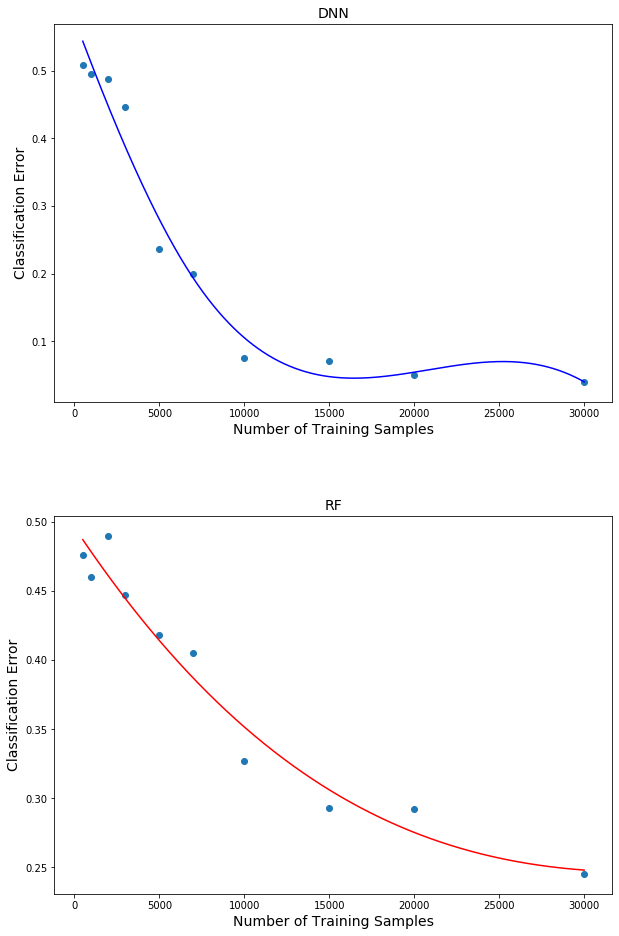

In [22]:
# Fit 1D curve using B-spline representation

from scipy.interpolate import splev, splrep

X_spline = np.asarray(sample_sizes)
y_spline_dnn = dnn_evolution_mean
y_spline_rf = rf_evolution_mean

x2 = np.linspace(500,30000,1000)

spl_dnn = splrep(X_spline,y_spline_dnn, k=3, s=0.01)
y2_dnn = splev(x2, spl_dnn)

spl_rf = splrep(X_spline,y_spline_rf, k=3, s=0.01)
y2_rf = splev(x2, spl_rf)

fig = plt.figure(figsize = (10,16))

ax = plt.subplot(211)
ax.plot(x2, y2_dnn, 'b')
ax.scatter(X_spline, y_spline_dnn) 
plt.title('DNN', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)

ax = plt.subplot(212)
ax.plot(x2, y2_rf, 'r')
ax.scatter(X_spline, y_spline_rf) 
plt.title('RF', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

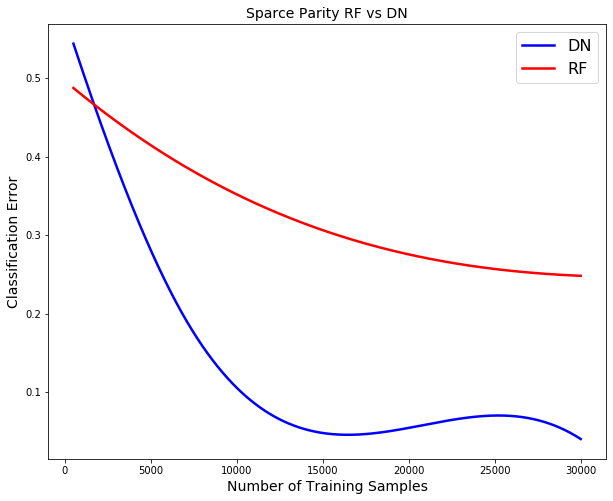

In [23]:
fig = plt.figure(figsize = (10,8))
ax = plt.subplot(111)

ax.plot(x2, y2_dnn, 'b', linewidth = 2.5)
ax.plot(x2, y2_rf, 'r', linewidth = 2.5)

plt.title('Sparce Parity RF vs DN', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.xlabel('Number of Training Samples', fontsize = 14)
plt.legend(['DN', 'RF'], prop={'size': 16})

fig.savefig('sparce_parity_2.png')